In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random

In [136]:


class VAE(keras.Model):
    def __init__(self):
        super(VAE,self).__init__()
        #encoder
        self.dim_reduce = 25
        self.fc_layer_1 = layers.Dense(128)
        self.fc_layer_2 = layers.Dense(self.dim_reduce)
        self.fc_layer_3 = layers.Dense(self.dim_reduce)

        self.fc_layer_4 = layers.Dense(128)
        self.fc_layer_5 = layers.Dense(64*64*3)
        

    def model_encoder(self, x):
        h = tf.nn.relu(self.fc_layer_1(x))
        mean_fc = self.fc_layer_2(h)
        var_fc = self.fc_layer_3(h)
        return mean_fc,var_fc

    def model_decoder(self, z):
        out = tf.nn.relu(self.fc_layer_4(z))
        out = self.fc_layer_5(out)
        return out

    def reparameter(self,mean_x,var_x):
        eps = tf.random.normal(var_x.shape)
        std = tf.exp(var_x)**0.5
        z = mean_x + std*eps
        return z

    def call(self, inputs, training=None):
        mean_x,var_x = self.model_encoder(inputs)
        z = self.reparameter(mean_x,var_x)
        x = self.model_decoder(z)
        return x,mean_x,var_x

In [137]:
#ANIME FACE

In [138]:
from PIL import Image

In [139]:
path = 'C:/Users/kevin/DeepLearning/HW2/VAE/anime-faces/data'

In [155]:
all_img = []
#for index in range(1,21552):
for index in range(1,15000):
    all_img.append(np.array(Image.open(path+'\\'+str(index)+'.png')))


In [157]:
def normalize(x):
    x = tf.cast(x,dtype=tf.float32)/255
    return x

test_img = tf.data.Dataset.from_tensor_slices(all_img)

train_img = test_img.map(normalize).batch(256)
test_img = test_img.map(normalize).batch(len(all_img))

#train_img = tf.data.Dataset.from_tensor_slices(all_img)


## HW2-1 (λ = 0.1)

In [160]:
λ = 0.1
anime_model = VAE()
optimizer = keras.optimizers.Adam(lr=0.001)
epoch = 35
loss_list=[]
for i in range(epoch):
    for step,x in enumerate(train_img):
        x = tf.reshape(x,[-1,64*64*3])
        with tf.GradientTape() as tape:
            logits,mean_x,var_x = anime_model(x)
            
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=logits)
            loss = tf.reduce_sum(loss)/x.shape[0]
            kl_div = -0.5*(var_x+1-mean_x**2-tf.exp(var_x))
            kl_div = tf.reduce_sum(kl_div)/x.shape[0]

            loss = loss + λ*kl_div
        grads = tape.gradient(loss,anime_model.trainable_variables)
        optimizer.apply_gradients(zip(grads,anime_model.trainable_variables))
        if step==0:
            print('epoch:',i,'step:',step,'loss:',float(loss),'kl_div:',float(kl_div))
    loss_list.append(loss.numpy())

  
    

epoch: 0 step: 0 loss: 8533.85546875 kl_div: 16.207530975341797
epoch: 1 step: 0 loss: 7503.44580078125 kl_div: 298.1485290527344
epoch: 2 step: 0 loss: 7214.36474609375 kl_div: 197.29263305664062
epoch: 3 step: 0 loss: 7181.79345703125 kl_div: 144.78164672851562
epoch: 4 step: 0 loss: 7134.53515625 kl_div: 136.79635620117188
epoch: 5 step: 0 loss: 7061.68212890625 kl_div: 130.70516967773438
epoch: 6 step: 0 loss: 7044.71044921875 kl_div: 113.6985855102539
epoch: 7 step: 0 loss: 7008.794921875 kl_div: 109.58991241455078
epoch: 8 step: 0 loss: 6950.51708984375 kl_div: 107.98780822753906
epoch: 9 step: 0 loss: 6907.685546875 kl_div: 109.6002197265625
epoch: 10 step: 0 loss: 6888.8447265625 kl_div: 105.67147064208984
epoch: 11 step: 0 loss: 6857.73095703125 kl_div: 106.58444213867188
epoch: 12 step: 0 loss: 6835.69384765625 kl_div: 105.557373046875
epoch: 13 step: 0 loss: 6810.015625 kl_div: 106.0479736328125
epoch: 14 step: 0 loss: 6798.65625 kl_div: 106.18083953857422
epoch: 15 step: 0 

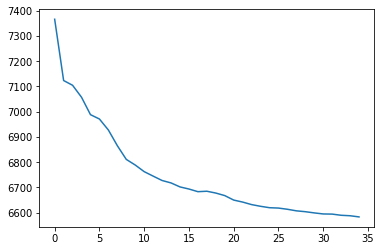

In [161]:
plt.plot(loss_list)

In [162]:
#TEST for Reconstruct
for x in test_img:
    val_x = tf.reshape(x,[-1,64*64*3])
    logits,_,_ = anime_model(val_x)
    x_hat = tf.sigmoid(logits)
    x_hat = tf.reshape(x_hat,[-1,64,64,3])
    x_hat = x_hat.numpy()
    #x_hat = x_hat.astype(np.uint8)



In [163]:
x_hat.shape

(14999, 64, 64, 3)

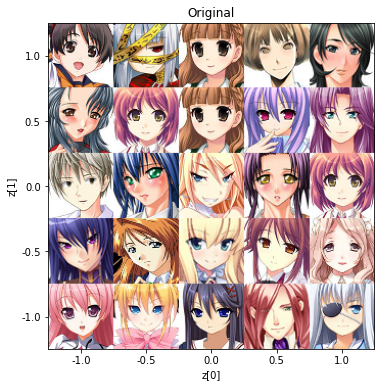

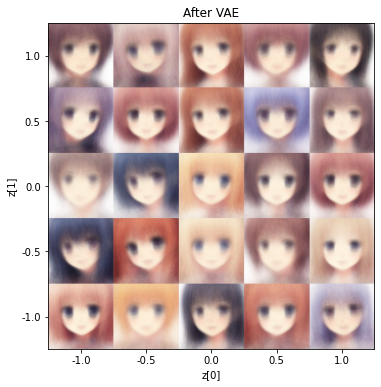

In [164]:
index_list = [random.randint(0,1000) for x in range(8*8)]

def plot(n=5, figsize=6):
    # display a n*n 2D manifold of digits
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n)
    
    
    for i in range(n):
        for j in range(n):
            digit = all_img[index_list[n*i+j]]/255
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,:
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('Original')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()
    
    for i in range(n):
        for j in range(n):
            digit = x_hat[index_list[n*i+j]]
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,:
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('After VAE')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot()

## HW2-2 (λ = 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


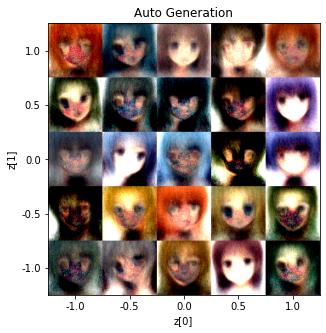

In [176]:


def generate_plot(vae,n=5, figsize=5):
    # display a n*n 2D manifold of digits
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n)
    
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            #random_z = np.array([np.random.normal(loc=np.mean(mean_x), scale=np.var(var_x),size=25)])
            random_z = np.array([np.random.normal(size=25)])
            random_z = tf.data.Dataset.from_tensor_slices(random_z)

            for z in random_z:
                z = tf.cast(z,dtype=tf.float32)
                z = tf.reshape(z,[-1,25])
                x = vae.model_decoder(z)
                digit = tf.reshape(x,[64,64,3])
                
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,:
            ] = digit+0.5
            
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('Auto Generation')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


generate_plot(anime_model)

## HW2-3 (λ = 0.1)

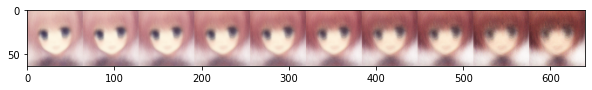

In [166]:
#set up the interpolation number
iprange = np.linspace(0,1,10)

def inter_plot(vae):
    digit_size=64
    n=10

    for x_random in test_img:
        real_x1 = x_random[random.randint(0,10000)]
        real_x2 = x_random[random.randint(0,10000)]

    figure = np.zeros((digit_size, digit_size*n ,3))

    for i, ip in enumerate(iprange):
        x = real_x1*ip + real_x2*(1-ip)
        val_x = tf.reshape(x,[-1,64*64*3])
        logits,_,_ = vae(val_x)
        x_hat = tf.sigmoid(logits)
        x_hat = tf.reshape(x_hat,[-1,64,64,3])
        x_hat = x_hat.numpy()  

        figure[
             0 : digit_size,
            i * digit_size : (i + 1) * digit_size,:

        ] = x_hat

    plt.figure(figsize=(10, 5))

    plt.imshow(figure)
    plt.show()
    
inter_plot(anime_model)

## HW2-1 (λ = 5)

In [169]:
λ = 5
anime_model2 = VAE()
optimizer = keras.optimizers.Adam(lr=0.001)
epoch = 35
loss_list2=[]
for i in range(epoch):
    for step,x in enumerate(train_img):
        x = tf.reshape(x,[-1,64*64*3])
        with tf.GradientTape() as tape:
            logits,mean_x,var_x = anime_model2(x)
            
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=logits)
            loss = tf.reduce_sum(loss)/x.shape[0]
            kl_div = -0.5*(var_x+1-mean_x**2-tf.exp(var_x))
            kl_div = tf.reduce_sum(kl_div)/x.shape[0]

            loss = loss + λ*kl_div
        grads = tape.gradient(loss,anime_model2.trainable_variables)
        optimizer.apply_gradients(zip(grads,anime_model2.trainable_variables))
        if step==0:
            print('epoch:',i,'step:',step,'loss:',float(loss),'kl_div:',float(kl_div))
    loss_list2.append(loss.numpy())

  
    

epoch: 0 step: 0 loss: 8572.70703125 kl_div: 9.2808256149292
epoch: 1 step: 0 loss: 7835.61328125 kl_div: 57.65290832519531
epoch: 2 step: 0 loss: 7445.9248046875 kl_div: 38.09905242919922
epoch: 3 step: 0 loss: 7329.7421875 kl_div: 31.701995849609375
epoch: 4 step: 0 loss: 7217.55712890625 kl_div: 28.450939178466797
epoch: 5 step: 0 loss: 7139.02734375 kl_div: 24.487667083740234
epoch: 6 step: 0 loss: 7050.57861328125 kl_div: 20.81653594970703
epoch: 7 step: 0 loss: 7003.66943359375 kl_div: 19.37542724609375
epoch: 8 step: 0 loss: 6987.4775390625 kl_div: 19.115867614746094
epoch: 9 step: 0 loss: 6970.4345703125 kl_div: 19.02521514892578
epoch: 10 step: 0 loss: 6953.3427734375 kl_div: 18.37851333618164
epoch: 11 step: 0 loss: 6942.3115234375 kl_div: 18.48218536376953
epoch: 12 step: 0 loss: 6931.47216796875 kl_div: 18.438549041748047
epoch: 13 step: 0 loss: 6921.42578125 kl_div: 18.370716094970703
epoch: 14 step: 0 loss: 6901.99658203125 kl_div: 18.812244415283203
epoch: 15 step: 0 los

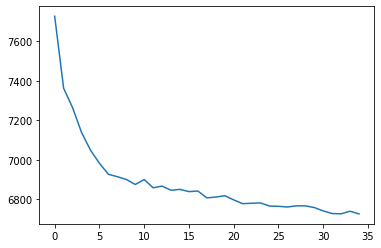

In [170]:
plt.plot(loss_list2)

In [172]:
#TEST for Reconstruct
for x in test_img:
    val_x = tf.reshape(x,[-1,64*64*3])
    logits,_,_ = anime_model2(val_x)
    x_hat2 = tf.sigmoid(logits)
    x_hat2 = tf.reshape(x_hat2,[-1,64,64,3])
    x_hat2 = x_hat2.numpy()
    #x_hat = x_hat.astype(np.uint8)



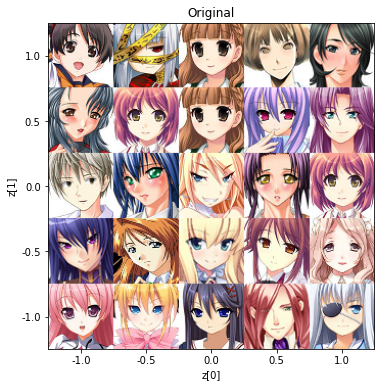

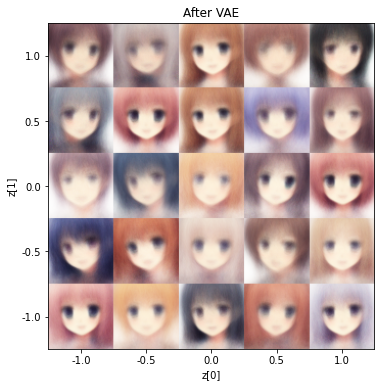

In [173]:
def plot(n=5, figsize=6):
    # display a n*n 2D manifold of digits
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n)
    
    
    for i in range(n):
        for j in range(n):
            digit = all_img[index_list[n*i+j]]/255
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,:
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('Original')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()
    
    for i in range(n):
        for j in range(n):
            digit = x_hat2[index_list[n*i+j]]
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,:
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.title('After VAE')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot()

## HW2-2 (λ = 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


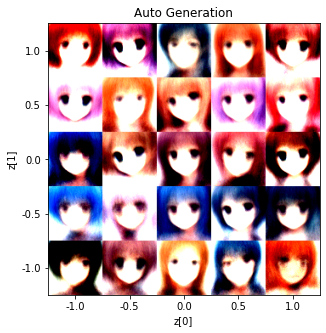

In [177]:
generate_plot(anime_model2)

## HW2-3 (λ = 5)

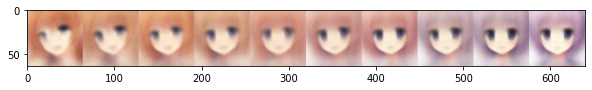

In [179]:
inter_plot(anime_model2)